# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Copy the contents from Google drive to local path in colab
#!cp -r '/content/drive/MyDrive/Project_data' '/content/sample_data/Project_data'

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 14 10:08:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import datetime
import os

In [ ]:
import cv2

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
# In this block, you read the folder names for training and validation.
# You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity.
# You keep increasing the batch size until the machine throws an error.

#gdrive path
#train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())

#local path
train_doc = np.random.permutation(open('/content/sample_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/sample_data/Project_data/val.csv').readlines())

In [ ]:
# Create a save path for saving the best models during each run with different parameters
save_path = '/content/drive/My Drive/Colab Notebooks/gesture/'
if not os.path.exists(save_path):
  os.mkdir(save_path)

save_path = '/content/drive/My Drive/Colab Notebooks/gesture/best_model/'
if not os.path.exists(save_path):
  os.mkdir(save_path)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given.

In [ ]:
#  In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 
#  You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.
def generator(source_path, folder_list, batch_size,resize_ht,resize_wd):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #print('folder_list = ', folder_list)
    #create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = int(len(t)/batch_size)
        # we iterate over the number of batches
        for batch in range(num_batches): 
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,18,resize_ht,resize_wd,3)) 
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            # iterate over the batch_size
            for folder in range(batch_size): 
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                #  Iterate iver the frames/images of a folder to read them in
                for idx,item in enumerate(img_idx): 
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #if image.shape[1] == 160:
                    #    image = cv2.resize(image[:,20:140,:],(resize_ht,resize_wd)).astype(np.float32)
                    #else:
                    #    image = cv2.resize(image,(resize_ht,resize_wd)).astype(np.float32)
                    image = cv2.resize(image,(resize_ht,resize_wd)).astype(np.float32)

                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels 

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),resize_ht,resize_wd,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #if image.shape[1] == 160:
                    #    image = cv2.resize(image[:,20:140,:],(resize_ht,resize_wd)).astype(np.float32)
                    #else:
                    #    image = cv2.resize(image,(resize_ht,resize_wd)).astype(np.float32)
                    image = cv2.resize(image,(resize_ht,resize_wd)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()

#gdrive path
#train_path = '/content/drive/My Drive/Project_data/train'
#val_path = '/content/drive/My Drive/Project_data/val'

#local path
train_path = '/content/sample_data/Project_data/train'
val_path = '/content/sample_data/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# Model 1
#
# with size of the image as 84x84
resize_ht = 84
resize_wd = 84
model_1 = Sequential()

#Input Layer
model_1.add(Conv3D(64,(3,3,3),padding='same',strides=(1,1,1),input_shape=(18,resize_ht,resize_wd,3)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden Layer
model_1.add(Conv3D(128,(3,3,3),padding='same',strides=(1,1,1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden Layer
model_1.add(Conv3D(256,(3,3,3),padding='same',strides=(1,1,1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden Layer
model_1.add(Conv3D(512,(3,3,3),padding='same',strides=(1,1,1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Flatten
model_1.add(Flatten())
model_1.add(Dropout(0.5))

#Fully Connected Layer
model_1.add(Dense(512,activation='relu'))
model_1.add(Dropout(0.5))

#Final Output Layer
model_1.add(Dense(5,activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# Set the optimizer parameters
optimiser = optimizers.SGD(learning_rate=0.001,decay=1e-6,momentum=0.7,nesterov=True)

#Compile the model. Capture the accuracy metrics
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Check the model parameters
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 84, 84, 64)   256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 42, 42, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 42, 42, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 42, 42, 128)   5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit`.

In [ ]:
# choose the number of epochs
num_epochs = 30
print ('# epochs =', num_epochs)
# Choose the batch size
batch_size = 32
print('# batch_size =',batch_size)

# Call the generator function for train and validation folders
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

# epochs = 30
# batch_size = 32


In [ ]:
# Pathname for saving the best model during each run
model_name = save_path + 'model_1' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)


filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Checkpoints when to save the best model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# Reduce learning rate when a metric has stopped improving till learning_rate=0.00001
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Early stopping if there is no improvement in validation loss for 12 consecutive epochs
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=12,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]
#callbacks_list = [checkpoint, LR]

In [ ]:
#The `steps_per_epoch` and `validation_steps` are used by `.fit()` to decide the number of next() calls it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
# Fit the model to start training
history_1=model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 3.0874 - categorical_accuracy: 0.3348Source path =  /content/sample_data/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 7.59542, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_1_2021-12-1410_12_30.987809/model-00001-3.08741-0.33484-7.59542-0.23000.h5
21/21 [==============================] - 34s 1s/step - loss: 3.0874 - categorical_accuracy: 0.3348 - val_loss: 7.5954 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6971 - categorical_accuracy: 0.4314
Epoch 00002: val_loss improved from 7.59542 to 5.12654, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_1_2021-12-1410_12_30.987809/model-00002-1.69707-0.43137-5.12654-0.19000.h5
21/21 [==============================] - 25s 1s/step - los

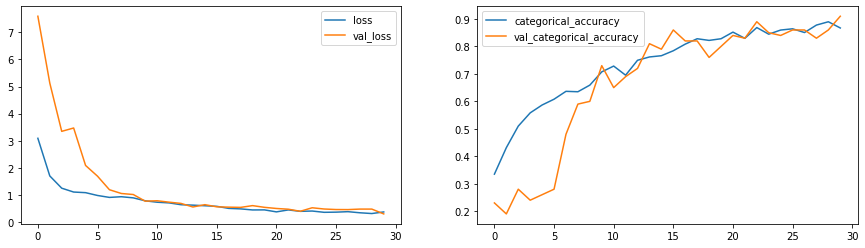

In [ ]:
# Plot the graphs for loss, validation loss, accuracy and validation accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_1.history['loss'])   
axes[0].plot(history_1.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_1.history['categorical_accuracy'])   
axes[1].plot(history_1.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model 2

In [ ]:
# Model -2
resize_ht = 140
resize_wd = 140

model_2 = Sequential()

#Input Layer
model_2.add(Conv3D(32,(3,3,3),padding='same',strides=(1,1,1),input_shape=(18,resize_ht,resize_wd,3)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden Layer
model_2.add(Conv3D(64,(3,3,3),padding='same',strides=(1,1,1)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden Layer
model_2.add(Conv3D(128,(3,3,3),padding='same',strides=(1,1,1)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden Layer
model_2.add(Conv3D(256,(3,3,3),padding='same',strides=(1,1,1)))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Flatten layer
model_2.add(Flatten())
model_2.add(Dropout(0.5))

# Fully Connected layer
model_2.add(Dense(256,activation='relu'))
model_2.add(Dropout(0.5))

# Final Output layer
model_2.add(Dense(5,activation='softmax'))


In [ ]:
#Lets see how ADAM optimizer performs
optimiser = optimizers.Adam(lr=0.001)

#Compile the model
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Check the model parameters
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 140, 140, 32)  2624      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 140, 140, 32)  128      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 140, 140, 32)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 70, 70, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 70, 70, 64)     55360     
                                                                 
 batch_normalization_5 (Batc  (None, 9, 70, 70, 64)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Batch size
batch_size=25

#Invoke the generator function for train and validation paths
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

In [ ]:
# Path and naming convention for saving the best model during the run
model_name = save_path + 'model_2' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Checkpoint parameters on when to save the best model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

# Early stopping when there is no improvement in the metric - validation loss
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

In [ ]:
# fit the model using the parameters set
history_2=model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 25
Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 7.8278 - categorical_accuracy: 0.3167Source path =  /content/sample_data/Project_data/val ; batch size = 25

Epoch 00001: val_loss improved from inf to 280.50922, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_2_2021-12-1410_39_43.780138/model-00001-7.82782-0.31674-280.50922-0.23000.h5
27/27 [==============================] - 30s 1s/step - loss: 7.8278 - categorical_accuracy: 0.3167 - val_loss: 280.5092 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 1.5612 - categorical_accuracy: 0.3318
Epoch 00002: val_loss improved from 280.50922 to 29.31895, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_2_2021-12-1410_39_43.780138/model-00002-1.56124-0.33183-29.31895-0.22000.h5
27/27 [==============================] - 29s 1s/

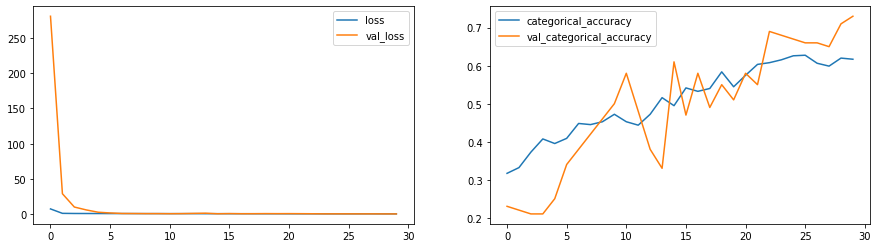

In [ ]:
# Plot the graphs for loss, validation loss, accuracy and validation accuracy of the latest model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_2.history['loss'])   
axes[0].plot(history_2.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_2.history['categorical_accuracy'])   
axes[1].plot(history_2.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model 3

In [ ]:
# Model -3 
resize_ht = 100
resize_wd = 100
model_3 = Sequential()

#Input Layer
model_3.add(Conv3D(32,(3,3,3),padding='same',strides=(1,1,1),input_shape=(18,resize_ht,resize_wd,3)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

# Hidden Layer
model_3.add(Conv3D(64,(3,3,3),padding='same',strides=(1,1,1)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

# Hidden Layer
model_3.add(Conv3D(128,(3,3,3),padding='same',strides=(1,1,1)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Hidden layer
model_3.add(Conv3D(256,(3,3,3),padding='same',strides=(1,1,1)))
model_3.add(BatchNormalization())
model_3.add(Activation('relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))

#Flatten layer
model_3.add(Flatten())
model_3.add(Dropout(0.5))

#Fully connected layer
model_3.add(Dense(256,activation='relu'))
model_3.add(Dropout(0.5))

# Final output layer - softmax
model_3.add(Dense(5,activation='softmax'))


In [ ]:
# Adam optimizer
optimiser = optimizers.Adam(lr=0.001)

# Compile the model
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Check the model parameters
print (model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 32)  2624      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 100, 100, 32)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 50, 50, 64)     55360     
                                                                 
 batch_normalization_9 (Batc  (None, 9, 50, 50, 64)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#batch size
batch_size=30

# call the generator function for train and validation paths
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

In [ ]:
# create the naming convention for saving the best model during the run
model_name = save_path + 'model_3' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# checkpoint parameters on when to save the model during each epoch
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

#earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

In [ ]:
# fit the model as per the parameters set
history_3=model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 4.5595 - categorical_accuracy: 0.3092Source path =  /content/sample_data/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 147.16617, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_3_2021-12-1410_58_13.320966/model-00001-4.55950-0.30920-147.16617-0.23000.h5
23/23 [==============================] - 25s 1s/step - loss: 4.5595 - categorical_accuracy: 0.3092 - val_loss: 147.1662 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
22/23 [===========================>..] - ETA: 0s - loss: 1.4075 - categorical_accuracy: 0.3894
Epoch 00002: val_loss improved from 147.16617 to 31.27704, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_3_2021-12-1410_58_13.320966/model-00002-1.40637-0.39065-31.27704-0.20000.h5
23/23 [==============================] - 25s 1s/

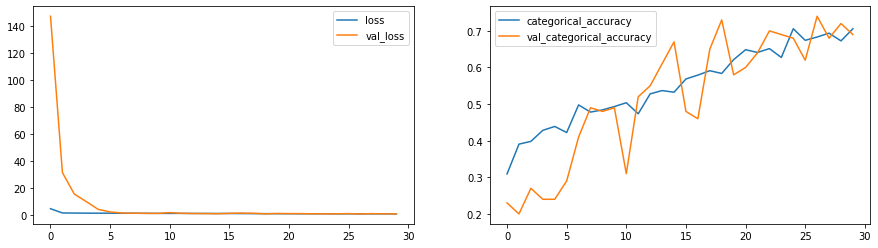

In [ ]:
# plot the graph on loss, validation loss, accuracy and validation accuracy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_3.history['loss'])   
axes[0].plot(history_3.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_3.history['categorical_accuracy'])   
axes[1].plot(history_3.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model 4

In [ ]:
# Model 4 - LSTM
resize_ht = 100
resize_wd = 100
model_4 = Sequential()

#Input layer
model_4.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=(18,resize_ht,resize_wd,3)))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

# Hidden layer
model_4.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

# Hidden layer
model_4.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

# Hidden layer
model_4.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

#Flatten
model_4.add(TimeDistributed(Flatten()))

#LSTM layer
model_4.add(LSTM(64))
model_4.add(Dropout(0.2))

#Fully Connected layer
model_4.add(Dense(64,activation='relu'))

model_4.add(Dropout(0.2))

#Output layer
model_4.add(Dense(5,activation='softmax'))


In [ ]:
# Adam optimizer with learning rate
optimiser = optimizers.Adam(learning_rate=0.001)

#Compile the model
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#Check the model summary
print (model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 50, 50, 32)  

In [ ]:
# Invoke the generator for train and validation directories
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

In [ ]:
#Create path for saving the best model
model_name = save_path + 'model_4' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Set the checkpoint parameters for saving the best models during each run
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

#earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

In [ ]:
# Fit the model based on the parameters set
history_4=model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.5466 - categorical_accuracy: 0.3092Source path =  /content/sample_data/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.71330, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_4_2021-12-1411_11_56.955008/model-00001-1.54657-0.30920-1.71330-0.23000.h5
23/23 [==============================] - 29s 1s/step - loss: 1.5466 - categorical_accuracy: 0.3092 - val_loss: 1.7133 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.3608 - categorical_accuracy: 0.4268
Epoch 00002: val_loss did not improve from 1.71330
23/23 [==============================] - 25s 1s/step - loss: 1.3608 - categorical_accuracy: 0.4268 - val_loss: 1.7721 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - E

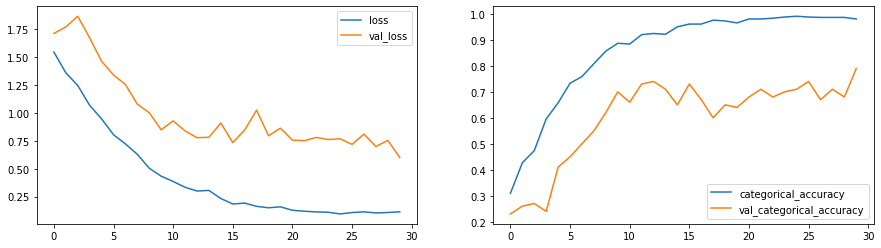

In [ ]:
# Plot the graphs for loss, categorical_accuracy, val_loss, val_categorical_loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_4.history['loss'])   
axes[0].plot(history_4.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_4.history['categorical_accuracy'])   
axes[1].plot(history_4.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model 5

In [ ]:
# Model-5 GRU
resize_ht = 100
resize_wd = 100
model_5 = Sequential()

#Input layer
model_5.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=(18,resize_ht,resize_wd,3)))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

#Hidden layer
model_5.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

#Hidden layer
model_5.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

#Hidden layer
model_5.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

#Flatten layer
model_5.add(TimeDistributed(Flatten()))

#GRU
model_5.add(GRU(64))
model_5.add(Dropout(0.2))

#Fully conneced dense layer
model_5.add(Dense(64,activation='relu'))
model_5.add(Dropout(0.2))

#Output layer
model_5.add(Dense(5,activation='softmax'))


In [ ]:
# Adam optimizer with learning rate parameter
optimiser = optimizers.Adam(learning_rate=0.001)

#compile the model
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#check the summary of the model
print (model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 18, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 18, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 18, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 50, 50, 32)  

In [ ]:
# Invoke the generator for train and validation directories
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

In [ ]:
#Create path for saving the best model
model_name = save_path + 'model_5' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Set the checkpoint parameters for saving the best models during each run
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

#earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

In [ ]:
# Fit the model based on the parameters set
history_5=model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.4798 - categorical_accuracy: 0.3499Source path =  /content/sample_data/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.85018, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_5_2021-12-1411_25_43.962527/model-00001-1.47976-0.34992-1.85018-0.23000.h5
23/23 [==============================] - 27s 1s/step - loss: 1.4798 - categorical_accuracy: 0.3499 - val_loss: 1.8502 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
22/23 [===========================>..] - ETA: 0s - loss: 1.1317 - categorical_accuracy: 0.5409
Epoch 00002: val_loss did not improve from 1.85018
23/23 [==============================] - 24s 1s/step - loss: 1.1335 - categorical_accuracy: 0.5400 - val_loss: 2.0181 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
22/23 [===========================>..] - E

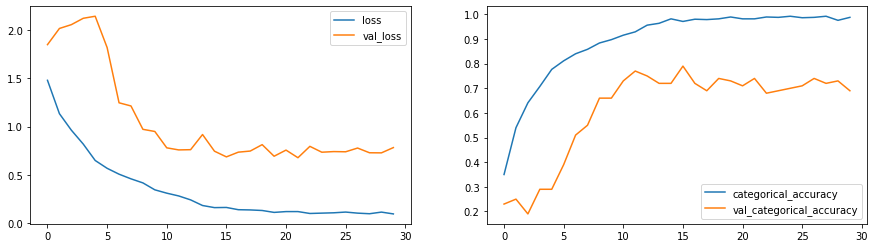

In [ ]:
# Plot the graphs for loss, categorical_accuracy, val_loss, val_categorical_loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_5.history['loss'])   
axes[0].plot(history_5.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_5.history['categorical_accuracy'])   
axes[1].plot(history_5.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model 6

In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. 

from keras.applications import mobilenet

In [ ]:
#Model-6 : Transfer Learning using MobileNet model
resize_ht=120
resize_wd=120
model_6 = Sequential()

#Input layer
model_6.add(TimeDistributed(mobilenet.MobileNet(weights='imagenet',include_top=False),input_shape=(18,resize_ht,resize_wd,3)))

# DO NOT train the mobilenet weights
for layer in model_6.layers:
  layer.trainable=False

model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2,2))))
#Flatten
model_6.add(TimeDistributed(Flatten()))
#LSTM
model_6.add(LSTM(64))
model_6.add(Dropout(0.2))
#Fully connected layer
model_6.add(Dense(64,activation='relu'))
model_6.add(Dropout(0.2))
#Output layer
model_6.add(Dense(5,activation='softmax'))

#Compile the model
model_6.compile(optimizer=optimizers.Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])


17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)               

In [ ]:
# Invoke the generator for train and validation directories
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

In [ ]:
#Create path for saving the best model
model_name = save_path + 'model_6' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Set the checkpoint parameters for saving the best models during each run
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

#earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

In [ ]:
# Fit the model based on the parameters set
history_6=model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.6054 - categorical_accuracy: 0.2443Source path =  /content/sample_data/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.52780, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_6_2021-12-1411_39_46.121076/model-00001-1.60536-0.24434-1.52780-0.43000.h5
23/23 [==============================] - 32s 1s/step - loss: 1.6054 - categorical_accuracy: 0.2443 - val_loss: 1.5278 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.2996 - categorical_accuracy: 0.5264
Epoch 00002: val_loss improved from 1.52780 to 1.46766, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_6_2021-12-1411_39_46.121076/model-00002-1.29962-0.52640-1.46766-0.38000.h5
23/23 [==============================] - 26s 1s/step - los

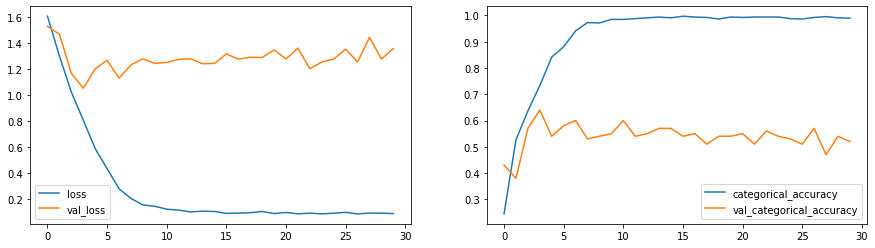

In [ ]:
# Plot the graphs for loss, categorical_accuracy, val_loss, val_categorical_loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_6.history['loss'])   
axes[0].plot(history_6.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_6.history['categorical_accuracy'])   
axes[1].plot(history_6.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Model-7

In [ ]:
#Model-7 : Transfer Learning using MobileNet and by training the mobilenet weights
resize_ht=160
resize_wd=160
model_7 = Sequential()

#Input layer
model_7.add(TimeDistributed(mobilenet.MobileNet(weights='imagenet',include_top=False),input_shape=(18,resize_ht,resize_wd,3)))

# TRAIN the mobilenet weights
#for layer in model_7.layers:
#  layer.trainable=False

model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2,2))))

#Flatten
model_7.add(TimeDistributed(Flatten()))

#GRU
model_7.add(GRU(64))
model_7.add(Dropout(0.2))

#Fully connected layer
model_7.add(Dense(64,activation='relu'))
model_7.add(Dropout(0.2))

# Output layer
model_7.add(Dense(5,activation='softmax'))

#Compile the model
model_7.compile(optimizer=optimizers.Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])


In [ ]:
#Check the model summary
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 18, 5, 5, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 18, 5, 5, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 18, 2, 2, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 4096)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)               

In [ ]:
# Invoke the generator for train and validation directories
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)

In [ ]:
#Create path for saving the best model
model_name = save_path + 'model_7' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Set the checkpoint parameters for saving the best models during each run
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

#earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]

In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1

In [ ]:
# Fit the model based on the parameters set
history_7=model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/sample_data/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 1.2163 - categorical_accuracy: 0.5204Source path =  /content/sample_data/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.08458, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_7_2021-12-1411_57_30.968173/model-00001-1.21635-0.52036-1.08458-0.56000.h5
23/23 [==============================] - 43s 2s/step - loss: 1.2163 - categorical_accuracy: 0.5204 - val_loss: 1.0846 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.5518 - categorical_accuracy: 0.8084
Epoch 00002: val_loss improved from 1.08458 to 0.97553, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_7_2021-12-1411_57_30.968173/model-00002-0.55180-0.80845-0.97553-0.59000.h5
23/23 [==============================] - 36s 2s/step - los

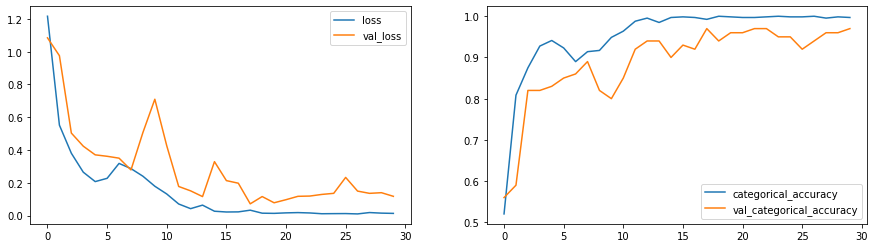

In [ ]:
# Plot the graphs for loss, categorical_accuracy, val_loss, val_categorical_loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_7.history['loss'])   
axes[0].plot(history_7.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_7.history['categorical_accuracy'])   
axes[1].plot(history_7.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

#Model -8

In [ ]:
# Model 8 GRU with kernel_Optimizer (Model-5-GRU options used as-is)

resize_ht = 100
resize_wd = 100
model_8 = Sequential()

#Input layer
model_8.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),input_shape=(18,resize_ht,resize_wd,3)))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Hidden Layer with Kernel_regularizer to reduce overfitting problem on Model#5
model_8.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.0001))))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Hidden Layer with Kernel_regularizer to reduce overfitting problem on Model#5
model_8.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.0001))))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Hidden Layer with Kernel_regularizer to reduce overfitting problem on Model#5
model_8.add(TimeDistributed(Conv2D(128,(3,3),padding='same',activation='relu',kernel_regularizer=l2(0.0001))))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))

#Flatten
model_8.add(TimeDistributed(Flatten()))

#GRU
model_8.add(GRU(64))
model_8.add(Dropout(0.2))

#Fully Connected layer with kernel_regularizer
model_8.add(Dense(64,activation='relu',kernel_regularizer=l2(0.0001)))
model_8.add(Dropout(0.2))

#Output layer
model_8.add(Dense(5,activation='softmax'))


In [ ]:
# Adam optimizer with learning rate parameter
optimiser = optimizers.Adam(learning_rate=0.001)

#Compile the model
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#Check the model summary
print (model_8.summary())


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_66 (TimeDi  (None, 18, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 18, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 18, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 18, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 18, 50, 50, 32) 

In [ ]:
# Invoke the generator for train and validation directories
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,resize_ht,resize_wd)
val_generator = generator(val_path, val_doc, batch_size,resize_ht,resize_wd)


In [ ]:
#Create path for saving the best model
model_name = save_path + 'model_8' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Set the checkpoint parameters for saving the best models during each run
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

#Reduce learning rate when a metric has stopped improving.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)

#earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR]


In [ ]:
#The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls 
#it need to make.
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_step_cnt = int(num_val_sequences/batch_size)
else:
    validation_step_cnt = (num_val_sequences//batch_size) + 1


In [ ]:
#Fit the model based on the parameters set
history_8=model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_step_cnt, class_weight=None, workers=1, initial_epoch=0)


Source path =  /content/sample_data/Project_data/train ; batch size = 30
Epoch 1/30
22/23 [===========================>..] - ETA: 0s - loss: 1.4878 - categorical_accuracy: 0.3773Source path =  /content/sample_data/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.93016, saving model to /content/drive/My Drive/Colab Notebooks/gesture/best_model/model_8_2021-12-1413_54_09.160392/model-00001-1.48851-0.37557-1.93016-0.23000.h5
23/23 [==============================] - 29s 1s/step - loss: 1.4885 - categorical_accuracy: 0.3756 - val_loss: 1.9302 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
22/23 [===========================>..] - ETA: 0s - loss: 1.2203 - categorical_accuracy: 0.5197
Epoch 00002: val_loss did not improve from 1.93016
23/23 [==============================] - 26s 1s/step - loss: 1.2182 - categorical_accuracy: 0.5204 - val_loss: 2.0317 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/30
22/23 [===========================>..] - E

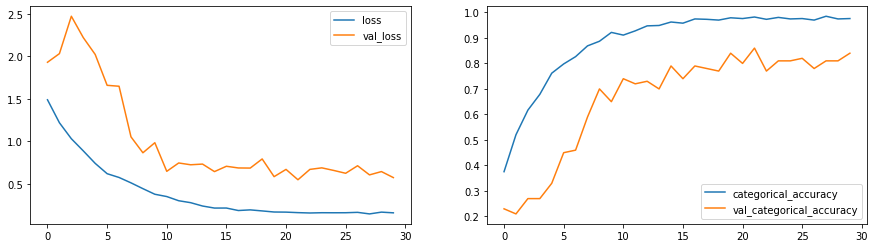

In [ ]:
# Plot the graphs for loss, categorical_accuracy, val_loss, val_categorical_loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_8.history['loss'])   
axes[0].plot(history_8.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[1].plot(history_8.history['categorical_accuracy'])   
axes[1].plot(history_8.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
# Summarize the models and their accuracy values
import pandas as pd

data=[
      ['1',model_1.count_params(),history_1.history['categorical_accuracy'][history_1.history['val_categorical_accuracy'].index(max(history_1.history['val_categorical_accuracy']))],max(history_1.history['val_categorical_accuracy'])],
      ['2',model_2.count_params(),history_2.history['categorical_accuracy'][history_2.history['val_categorical_accuracy'].index(max(history_2.history['val_categorical_accuracy']))],max(history_2.history['val_categorical_accuracy'])],
      ['3',model_3.count_params(),history_3.history['categorical_accuracy'][history_3.history['val_categorical_accuracy'].index(max(history_3.history['val_categorical_accuracy']))],max(history_3.history['val_categorical_accuracy'])],
      ['4',model_4.count_params(),history_4.history['categorical_accuracy'][history_4.history['val_categorical_accuracy'].index(max(history_4.history['val_categorical_accuracy']))],max(history_4.history['val_categorical_accuracy'])],
      ['5',model_5.count_params(),history_5.history['categorical_accuracy'][history_5.history['val_categorical_accuracy'].index(max(history_5.history['val_categorical_accuracy']))],max(history_5.history['val_categorical_accuracy'])],
      ['6',model_6.count_params(),history_6.history['categorical_accuracy'][history_6.history['val_categorical_accuracy'].index(max(history_6.history['val_categorical_accuracy']))],max(history_6.history['val_categorical_accuracy'])],
      ['7',model_7.count_params(),history_7.history['categorical_accuracy'][history_7.history['val_categorical_accuracy'].index(max(history_7.history['val_categorical_accuracy']))],max(history_7.history['val_categorical_accuracy'])],
      ['8',model_8.count_params(),history_8.history['categorical_accuracy'][history_8.history['val_categorical_accuracy'].index(max(history_8.history['val_categorical_accuracy']))],max(history_8.history['val_categorical_accuracy'])]
      ]

summary_df = pd.DataFrame(data,columns=['Model#','No.of Parameters','Training accuracy','Best_val_accuracy'])

summary_df.style.hide_index()

Model#,No.of Parameters,Training accuracy,Best_val_accuracy
1,11211525,0.867270,0.910000
2,5362053,0.616893,0.730000
3,3527045,0.683258,0.740000
4,1299173,0.980392,0.790000
5,1000293,0.971342,0.790000
6,3516229,0.733032,0.640000
7,4036549,0.992459,0.970000
8,1000293,0.981900,0.860000


In [ ]:
from keras.models import load_model

In [ ]:
# Load the best model based on the metrics other than the model -
# generated using transfer learning - i.e., model#8 - epoch 022 run.
final_model = load_model('/content/drive/My Drive/Colab Notebooks/gesture/best_model/model_8_2021-12-1413_54_09.160392/model-00022-0.16038-0.98190-0.54725-0.86000.h5')

In [ ]:
final_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_66 (TimeDi  (None, 18, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 18, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 18, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 18, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 18, 50, 50, 32) 